In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os, os.path
import csv
import numpy
from scipy import interpolate
from scipy.ndimage.filters import gaussian_filter1d
from galpy.potential import LogarithmicHaloPotential
from galpy.orbit import Orbit
from galpy.actionAngle import actionAngleIsochroneApprox
from galpy.snapshot import nemo_util
from galpy.df import impulse_deltav_plummer_curvedstream, \
    impulse_deltav_plummerstream_curvedstream
import seaborn as sns
import matplotlib.lines as mlines
from galpy.util import bovy_plot, bovy_coords, bovy_conversion, multi
%pylab inline
from stream2_util import rectangular_to_cylindrical, R0, V0, lp, calc_apar, calc_aA_sim
import calc_deltav
save_figures= False

Populating the interactive namespace from numpy and matplotlib


# Analysis of the NEMO snapshots of impacts of a GC stream with a DM stream

##Just before the impact

We introduce the DM stream 0.125 NEMO time units (~120 Myr) before the point of closest approach. This is what the DM snapshots look like then, compared to where the GC stream is at the time of impact (thus, the two streams are not shown at the same time here). We also show the orbit that the DM will take.

In [3]:
# GC
filename= os.path.join(os.getenv('DATADIR'),'bovy','stream-stream',
                       'gc_evol_unp_atimpact.dat')
snap_gc= nemo_util.read(filename,swapyz=True)
# Various DM streams
filename= os.path.join(os.getenv('DATADIR'),'bovy','stream-stream',
                       'dm_evol_0.50_untilimpact.dat')
snap_dm0p5= nemo_util.read(filename,swapyz=True)
filename= os.path.join(os.getenv('DATADIR'),'bovy','stream-stream',
                       'dm_evol_0.25_untilimpact.dat')
snap_dm0p25= nemo_util.read(filename,swapyz=True)
filename= os.path.join(os.getenv('DATADIR'),'bovy','stream-stream',
                       'dm_evol_0.375_untilimpact.dat')
snap_dm0p375= nemo_util.read(filename,swapyz=True)
filename= os.path.join(os.getenv('DATADIR'),'bovy','stream-stream',
                       'dm_evol_0.125_untilimpact.dat')
snap_dm0p125= nemo_util.read(filename,swapyz=True)

In [4]:
# DM at the time of impact
xv_dm_impact= numpy.array([-13.500000,2.840000,-1.840000,6.82200571,132.7700529,149.4174464])
RvR_dm_impact= rectangular_to_cylindrical(xv_dm_impact[:,numpy.newaxis].T)[0,:]
dm_impact= Orbit([RvR_dm_impact[0]/R0,RvR_dm_impact[1]/V0,RvR_dm_impact[2]/V0,
                  RvR_dm_impact[3]/R0,RvR_dm_impact[4]/V0,RvR_dm_impact[5]],ro=R0,vo=V0)
dm_impact= dm_impact.flip()
# Integrate to 0.125 time units earlier
times= numpy.linspace(0.,0.125*0.9777922212082034/bovy_conversion.time_in_Gyr(V0,R0),1001)
dm_impact.integrate(times,lp)
dm_forward= dm_impact(times[-1]).flip()
times= numpy.linspace(0.,0.250*0.9777922212082034/bovy_conversion.time_in_Gyr(V0,R0),1001)
dm_forward.integrate(times,lp)

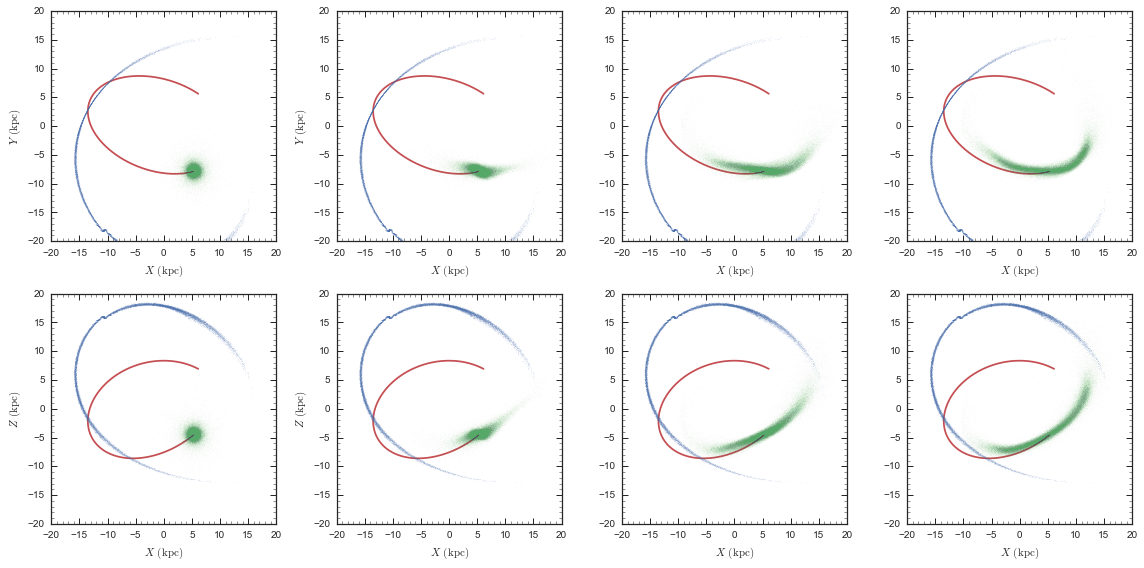

In [5]:
figsize(16,8)
subplot(2,4,1)
bovy_plot.bovy_plot(snap_gc[:,1,-1],snap_gc[:,2,-1],',',alpha=0.05,
                    color=sns.color_palette()[0],zorder=1,
                    xrange=[-20.,20.],yrange=[-20.,20],
                    xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$Y\,(\mathrm{kpc})$',
                    gcf=True)
plot(snap_dm0p125[:,1,-1],snap_dm0p125[:,2,-1],',',alpha=0.01,color=sns.color_palette()[1],zorder=2)
dm_forward.plot(d1='x',d2='y',overplot=True,color=sns.color_palette()[2],zorder=0)
subplot(2,4,2)
bovy_plot.bovy_plot(snap_gc[:,1,-1],snap_gc[:,2,-1],',',alpha=0.05,
                    color=sns.color_palette()[0],zorder=1,
                    xrange=[-20.,20.],yrange=[-20.,20],
                    xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$Y\,(\mathrm{kpc})$',
                    gcf=True)
plot(snap_dm0p25[:,1,-1],snap_dm0p25[:,2,-1],',',alpha=0.01,color=sns.color_palette()[1],zorder=2)
dm_forward.plot(d1='x',d2='y',overplot=True,color=sns.color_palette()[2],zorder=0)
subplot(2,4,3)
bovy_plot.bovy_plot(snap_gc[:,1,-1],snap_gc[:,2,-1],',',alpha=0.05,
                    color=sns.color_palette()[0],zorder=1,
                    xrange=[-20.,20.],yrange=[-20.,20],
                    xlabel=r'$X\,(\mathrm{kpc})$',
                    gcf=True)
plot(snap_dm0p375[:,1,-1],snap_dm0p375[:,2,-1],',',alpha=0.01,color=sns.color_palette()[1],zorder=2)
dm_forward.plot(d1='x',d2='y',overplot=True,color=sns.color_palette()[2],zorder=0)
subplot(2,4,4)
bovy_plot.bovy_plot(snap_gc[:,1,-1],snap_gc[:,2,-1],',',alpha=0.05,
                    color=sns.color_palette()[0],zorder=1,
                    xrange=[-20.,20.],yrange=[-20.,20],
                    xlabel=r'$X\,(\mathrm{kpc})$',
                    gcf=True)
plot(snap_dm0p5[:,1,-1],snap_dm0p5[:,2,-1],',',alpha=0.01,color=sns.color_palette()[1],zorder=2)
dm_forward.plot(d1='x',d2='y',overplot=True,color=sns.color_palette()[2],zorder=0)
tight_layout()
subplot(2,4,5)
bovy_plot.bovy_plot(snap_gc[:,1,-1],snap_gc[:,3,-1],',',alpha=0.05,
                    color=sns.color_palette()[0],zorder=1,
                    xrange=[-20.,20.],yrange=[-20.,20],
                    xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$Z\,(\mathrm{kpc})$',
                    gcf=True)
plot(snap_dm0p125[:,1,-1],snap_dm0p125[:,3,-1],',',alpha=0.01,color=sns.color_palette()[1],zorder=2)
dm_forward.plot(d1='x',d2='z',overplot=True,color=sns.color_palette()[2],zorder=0)
subplot(2,4,6)
bovy_plot.bovy_plot(snap_gc[:,1,-1],snap_gc[:,3,-1],',',alpha=0.05,
                    color=sns.color_palette()[0],zorder=1,
                    xrange=[-20.,20.],yrange=[-20.,20],
                    xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$Z\,(\mathrm{kpc})$',
                    gcf=True)
plot(snap_dm0p25[:,1,-1],snap_dm0p25[:,3,-1],',',alpha=0.01,color=sns.color_palette()[1],zorder=2)
dm_forward.plot(d1='x',d2='z',overplot=True,color=sns.color_palette()[2],zorder=0)
subplot(2,4,7)
bovy_plot.bovy_plot(snap_gc[:,1,-1],snap_gc[:,3,-1],',',alpha=0.05,
                    color=sns.color_palette()[0],zorder=1,
                    xrange=[-20.,20.],yrange=[-20.,20],
                    xlabel=r'$X\,(\mathrm{kpc})$',
                    gcf=True)
plot(snap_dm0p375[:,1,-1],snap_dm0p375[:,3,-1],',',alpha=0.01,color=sns.color_palette()[1],zorder=2)
dm_forward.plot(d1='x',d2='z',overplot=True,color=sns.color_palette()[2],zorder=0)
subplot(2,4,8)
bovy_plot.bovy_plot(snap_gc[:,1,-1],snap_gc[:,3,-1],',',alpha=0.05,
                    color=sns.color_palette()[0],zorder=1,
                    xrange=[-20.,20.],yrange=[-20.,20],
                    xlabel=r'$X\,(\mathrm{kpc})$',
                    gcf=True)
plot(snap_dm0p5[:,1,-1],snap_dm0p5[:,3,-1],',',alpha=0.01,color=sns.color_palette()[1],zorder=2)
dm_forward.plot(d1='x',d2='z',overplot=True,color=sns.color_palette()[2],zorder=0)
tight_layout()

## After impact

Here is what the streams looks like after the impact:

In [6]:
# Snapshots are now combined, read various DM streams
filename= os.path.join(os.getenv('DATADIR'),'bovy','stream-stream',
                       'gcdm_evol_0.50_afterimpact.dat')
snap_dm0p5_after= nemo_util.read(filename,swapyz=True)
filename= os.path.join(os.getenv('DATADIR'),'bovy','stream-stream',
                       'gcdm_evol_0.375_afterimpact.dat')
snap_dm0p375_after= nemo_util.read(filename,swapyz=True)
filename= os.path.join(os.getenv('DATADIR'),'bovy','stream-stream',
                       'gcdm_evol_0.25_afterimpact.dat')
snap_dm0p25_after= nemo_util.read(filename,swapyz=True)
filename= os.path.join(os.getenv('DATADIR'),'bovy','stream-stream',
                       'gcdm_evol_0.125_afterimpact.dat')
snap_dm0p125_after= nemo_util.read(filename,swapyz=True)

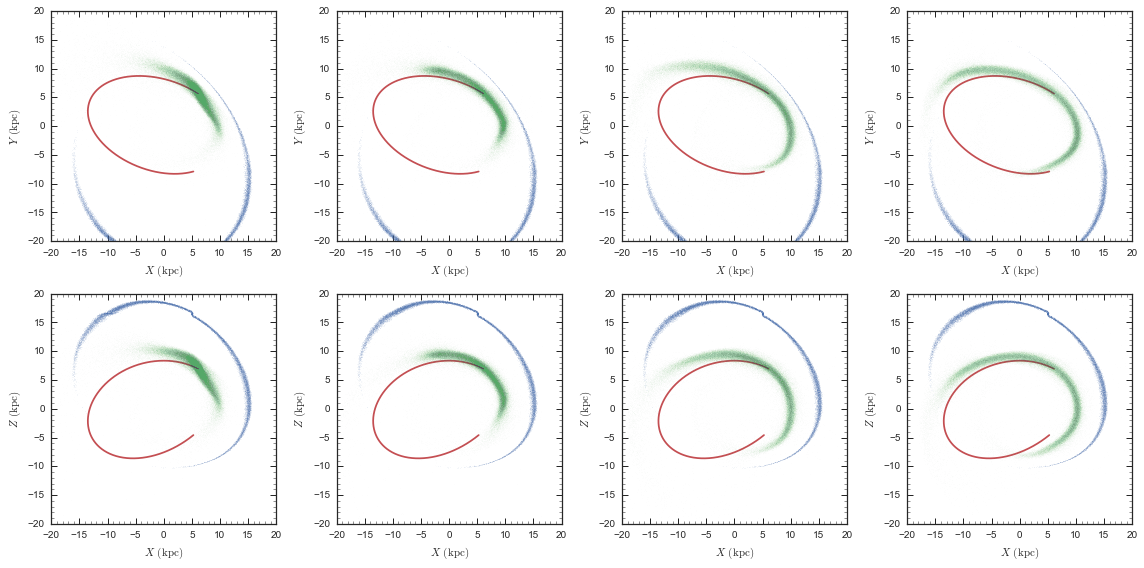

In [7]:
figsize(16,8)
subplot(2,4,1)
bovy_plot.bovy_plot(snap_dm0p125_after[:100000,1,-1],
                    snap_dm0p125_after[:100000,2,-1],
                    ',',alpha=0.05,
                    color=sns.color_palette()[0],zorder=1,
                    xrange=[-20.,20.],yrange=[-20.,20],
                    xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$Y\,(\mathrm{kpc})$',
                    gcf=True)
plot(snap_dm0p125_after[100000:,1,-1],snap_dm0p125_after[100000:,2,-1],
     ',',alpha=0.01,color=sns.color_palette()[1],zorder=2)
dm_forward.plot(d1='x',d2='y',overplot=True,color=sns.color_palette()[2],zorder=0)
subplot(2,4,2)
bovy_plot.bovy_plot(snap_dm0p25_after[:100000,1,-1],
                    snap_dm0p25_after[:100000,2,-1],
                    ',',alpha=0.05,
                    color=sns.color_palette()[0],zorder=1,
                    xrange=[-20.,20.],yrange=[-20.,20],
                    xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$Y\,(\mathrm{kpc})$',
                    gcf=True)
plot(snap_dm0p25_after[100000:,1,-1],snap_dm0p25_after[100000:,2,-1],
     ',',alpha=0.01,color=sns.color_palette()[1],zorder=2)
dm_forward.plot(d1='x',d2='y',overplot=True,color=sns.color_palette()[2],zorder=0)
subplot(2,4,3)
bovy_plot.bovy_plot(snap_dm0p375_after[:100000,1,-1],
                    snap_dm0p375_after[:100000,2,-1],
                    ',',alpha=0.05,
                    color=sns.color_palette()[0],zorder=1,
                    xrange=[-20.,20.],yrange=[-20.,20],
                    xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$Y\,(\mathrm{kpc})$',
                    gcf=True)
plot(snap_dm0p375_after[100000:,1,-1],snap_dm0p375_after[100000:,2,-1],
     ',',alpha=0.01,color=sns.color_palette()[1],zorder=2)
dm_forward.plot(d1='x',d2='y',overplot=True,color=sns.color_palette()[2],zorder=0)
subplot(2,4,4)
bovy_plot.bovy_plot(snap_dm0p5_after[:100000,1,-1],
                    snap_dm0p5_after[:100000,2,-1],
                    ',',alpha=0.05,
                    color=sns.color_palette()[0],zorder=1,
                    xrange=[-20.,20.],yrange=[-20.,20],
                    xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$Y\,(\mathrm{kpc})$',
                    gcf=True)
plot(snap_dm0p5_after[100000:,1,-1],snap_dm0p5_after[100000:,2,-1],
     ',',alpha=0.01,color=sns.color_palette()[1],zorder=2)
dm_forward.plot(d1='x',d2='y',overplot=True,color=sns.color_palette()[2],zorder=0)
subplot(2,4,5)
bovy_plot.bovy_plot(snap_dm0p125_after[:100000,1,-1],
                    snap_dm0p125_after[:100000,3,-1],
                    ',',alpha=0.05,
                    color=sns.color_palette()[0],zorder=1,
                    xrange=[-20.,20.],yrange=[-20.,20],
                    xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$Z\,(\mathrm{kpc})$',
                    gcf=True)
plot(snap_dm0p125_after[100000:,1,-1],snap_dm0p125_after[100000:,3,-1],
     ',',alpha=0.01,color=sns.color_palette()[1],zorder=2)
dm_forward.plot(d1='x',d2='z',overplot=True,color=sns.color_palette()[2],zorder=0)
subplot(2,4,6)
bovy_plot.bovy_plot(snap_dm0p25_after[:100000,1,-1],
                    snap_dm0p25_after[:100000,3,-1],
                    ',',alpha=0.05,
                    color=sns.color_palette()[0],zorder=1,
                    xrange=[-20.,20.],yrange=[-20.,20],
                    xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$Z\,(\mathrm{kpc})$',
                    gcf=True)
plot(snap_dm0p25_after[100000:,1,-1],snap_dm0p25_after[100000:,3,-1],
     ',',alpha=0.01,color=sns.color_palette()[1],zorder=2)
dm_forward.plot(d1='x',d2='z',overplot=True,color=sns.color_palette()[2],zorder=0)
subplot(2,4,7)
bovy_plot.bovy_plot(snap_dm0p375_after[:100000,1,-1],
                    snap_dm0p375_after[:100000,3,-1],
                    ',',alpha=0.05,
                    color=sns.color_palette()[0],zorder=1,
                    xrange=[-20.,20.],yrange=[-20.,20],
                    xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$Z\,(\mathrm{kpc})$',
                    gcf=True)
plot(snap_dm0p375_after[100000:,1,-1],snap_dm0p375_after[100000:,3,-1],
     ',',alpha=0.01,color=sns.color_palette()[1],zorder=2)
dm_forward.plot(d1='x',d2='z',overplot=True,color=sns.color_palette()[2],zorder=0)
subplot(2,4,8)
bovy_plot.bovy_plot(snap_dm0p5_after[:100000,1,-1],
                    snap_dm0p5_after[:100000,3,-1],
                    ',',alpha=0.05,
                    color=sns.color_palette()[0],zorder=1,
                    xrange=[-20.,20.],yrange=[-20.,20],
                    xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$Z\,(\mathrm{kpc})$',
                    gcf=True)
plot(snap_dm0p5_after[100000:,1,-1],snap_dm0p5_after[100000:,3,-1],
     ',',alpha=0.01,color=sns.color_palette()[1],zorder=2)
dm_forward.plot(d1='x',d2='z',overplot=True,color=sns.color_palette()[2],zorder=0)
tight_layout()

## Before and after on the same figure

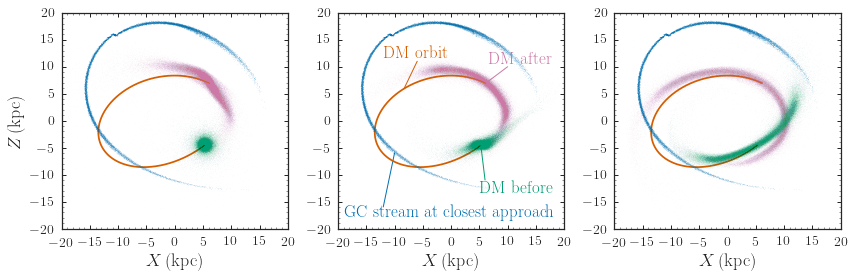

In [8]:
if save_figures:
    alpha_gc= 1.
    alpha_dm= 0.5
else:
    alpha_gc= 0.05
    alpha_dm= 0.01
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(12,4)
subplot(1,3,1)
bovy_plot.bovy_plot(snap_gc[:,1,-1],snap_gc[:,3,-1],',',alpha=alpha_gc,
                    color=sns.color_palette("colorblind")[0],zorder=3,
                    xrange=[-20.,20.],yrange=[-20.,20],
                    xlabel=r'$X\,(\mathrm{kpc})$',
                    ylabel=r'$Z\,(\mathrm{kpc})$',
                    rasterized=True,
                    gcf=True)
plot(snap_dm0p125[:,1,-1],snap_dm0p125[:,3,-1],',',color=sns.color_palette("colorblind")[1],
     zorder=5,alpha=alpha_dm,rasterized=True)
plot(snap_dm0p125_after[100000:,1,-1],snap_dm0p125_after[100000:,3,-1],
     ',',alpha=alpha_dm,rasterized=True,color=sns.color_palette("colorblind")[3],zorder=4)
dm_forward.plot(d1='x',d2='z',overplot=True,color=sns.color_palette("colorblind")[2],zorder=2)

subplot(1,3,2)
bovy_plot.bovy_plot(snap_gc[:,1,-1],snap_gc[:,3,-1],',',alpha=alpha_gc,
                    color=sns.color_palette("colorblind")[0],zorder=3,
                    xrange=[-20.,20.],yrange=[-20.,20],rasterized=True,
                    xlabel=r'$X\,(\mathrm{kpc})$',
                    gcf=True)
plot(snap_dm0p25[:,1,-1],snap_dm0p25[:,3,-1],',',alpha=alpha_dm,color=sns.color_palette("colorblind")[1],
     rasterized=True,zorder=5)
plot(snap_dm0p25_after[100000:,1,-1],snap_dm0p25_after[100000:,3,-1],
     ',',rasterized=True,alpha=alpha_dm,color=sns.color_palette("colorblind")[3],zorder=4)
dm_forward.plot(d1='x',d2='z',overplot=True,color=sns.color_palette("colorblind")[2],zorder=2)# Label GC stream
plot([-10.,-12.],[-6.,-16.],
    '-',lw=1.,color=sns.color_palette("colorblind")[0],zorder=0)
bovy_plot.bovy_text(-19.,-18,r'$\mathrm{GC\ stream\ at\ closest\ approach}$',
                    color=sns.color_palette("colorblind")[0],size=17.)
# Label DM before
plot([numpy.nanmedian(snap_dm0p125[:,1,-1]),6],[numpy.nanmedian(snap_dm0p125[:,3,-1]),-11],
    '-',lw=1.,color=sns.color_palette("colorblind")[1])
bovy_plot.bovy_text(5.,-13.5,r'$\mathrm{DM\ before}$',color=sns.color_palette("colorblind")[1],size=17.)
# Label DM after, pfff
plot([dm_forward.x(0.25*0.9777922212082034/bovy_conversion.time_in_Gyr(V0,R0)),10],
     [dm_forward.z(0.25*0.9777922212082034/bovy_conversion.time_in_Gyr(V0,R0)),10],
    '-',lw=1.,color=sns.color_palette("colorblind")[3])
bovy_plot.bovy_text(6.5,10.5,r'$\mathrm{DM\ after}$',color=sns.color_palette("colorblind")[3],size=17.)
# Label DM orbit, pfff
plot([dm_forward.x(0.18*0.9777922212082034/bovy_conversion.time_in_Gyr(V0,R0)),-6.],
     [dm_forward.z(0.18*0.9777922212082034/bovy_conversion.time_in_Gyr(V0,R0)),11],
    '-',lw=1.,color=sns.color_palette("colorblind")[2])
bovy_plot.bovy_text(-12.,11.5,r'$\mathrm{DM\ orbit}$',color=sns.color_palette("colorblind")[2],size=17.)

subplot(1,3,3)
bovy_plot.bovy_plot(snap_gc[:,1,-1],snap_gc[:,3,-1],',',alpha=alpha_gc,
                    color=sns.color_palette("colorblind")[0],zorder=3,
                    xrange=[-20.,20.],yrange=[-20.,20],rasterized=True,
                    xlabel=r'$X\,(\mathrm{kpc})$',
                    gcf=True)
plot(snap_dm0p5[:,1,-1],snap_dm0p5[:,3,-1],',',alpha=alpha_dm,color=sns.color_palette("colorblind")[1],
     rasterized=True,zorder=5)
plot(snap_dm0p5_after[100000:,1,-1],snap_dm0p5_after[100000:,3,-1],
     ',',rasterized=True,alpha=alpha_dm,color=sns.color_palette("colorblind")[3],zorder=4)
dm_forward.plot(d1='x',d2='z',overplot=True,color=sns.color_palette("colorblind")[2],zorder=2)
tight_layout()
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2015-stream-stream','fig2.pdf'),
                            dpi=400)

## Action-angle coordinates for the stream

In this section, we compute the action-angle coordinates for all of the particles in the unperturbed stream at the time of impact to aid in the analysis. The distribution of radial frequency vs. parallel angle is:

In [9]:
aa_filename= os.path.join(os.getenv('DATADIR'),'bovy','stream-stream',
                         'gc_evol_unp_aa.dat')
# Cylindrical coordinates for everything
RvR= rectangular_to_cylindrical(snap_gc[:,1:,-1])
acfs= calc_aA_sim(RvR,aa_filename,snap_gc)

In [10]:
apar= calc_apar(acfs)

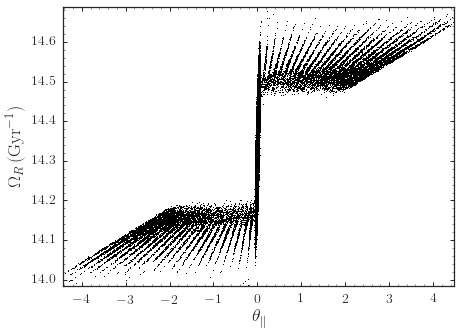

In [11]:
figsize(7,5)
bovy_plot.bovy_plot(apar,
                    acfs[3]*bovy_conversion.freq_in_Gyr(V0,R0),'k,',
                    xlabel=r'$\theta_\parallel$',
                    ylabel=r'$\Omega_R\,(\mathrm{Gyr}^{-1})$')

The density in the GC stream is

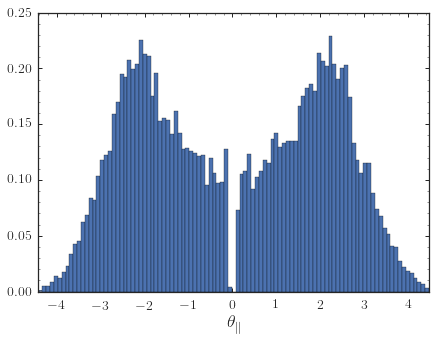

In [12]:
thetap= (numpy.pi+(acfs[7]-numpy.median(acfs[7]))) % (2.*numpy.pi)
debrisIndx= numpy.fabs(thetap-numpy.pi) > (6.*numpy.median(numpy.fabs(thetap-numpy.median(thetap))))
dum= bovy_plot.bovy_hist(apar[debrisIndx],bins=101,normed=True,
                        xlabel=r'$\theta_\parallel$')

## Action angle coordinates for the DM streams

We compute action-angle coordinates for all particles in the DM streams before and after impact and show the fractional difference in the angle evolution wrt the free-streaming (test-particle) case. The two longest DM streams are basically flowing as test-particles, the two shortest have a significant remaining progenitor:

In [13]:
aa_filenames= [os.path.join(os.getenv('DATADIR'),
                            'bovy','stream-stream',fname)
               for fname in ['dm_evol_0.125_untilimpact_aa.dat',
                             'dm_evol_0.25_untilimpact_aa.dat',
                             'dm_evol_0.375_untilimpact_aa.dat',
                             'dm_evol_0.50_untilimpact_aa.dat',
                             'gcdm_evol_0.125_afterimpact_aa.dat',
                             'gcdm_evol_0.25_afterimpact_aa.dat',
                             'gcdm_evol_0.375_afterimpact_aa.dat',
                             'gcdm_evol_0.50_afterimpact_aa.dat']]
RvRs= [rectangular_to_cylindrical(snap[:,1:,-1])
      for snap in [snap_dm0p125,snap_dm0p25,
                   snap_dm0p375,snap_dm0p5]]
RvRs.extend([rectangular_to_cylindrical(snap[100000:,1:,-1])
      for snap in [snap_dm0p125_after,snap_dm0p25_after,
                   snap_dm0p375_after,snap_dm0p5_after]])
for aa_filename, RvR in zip(aa_filenames,RvRs):
    dum= calc_aA_sim(RvR,aa_filename,snap_gc)

In [14]:
# Load the 0.125 one
acfs_0p125_until= calc_aA_sim(None,os.path.join(os.getenv('DATADIR'),'bovy',
                                                'stream-stream','dm_evol_0.125_untilimpact_aa.dat'),None) # No need for RvR
acfs_0p125_after= calc_aA_sim(None,os.path.join(os.getenv('DATADIR'),'bovy',
                                                'stream-stream','gcdm_evol_0.125_afterimpact_aa.dat'),None) # No need for RvR
thetap= (numpy.pi+(acfs_0p125_after[7]-numpy.nanmedian(acfs_0p125_after[7]))) % (2.*numpy.pi)
debrisIndx_0p125= numpy.fabs(thetap-numpy.pi) > (4.*numpy.nanmedian(numpy.fabs(thetap-numpy.nanmedian(thetap))))
# Load the 0.25 one
acfs_0p25_until= calc_aA_sim(None,os.path.join(os.getenv('DATADIR'),'bovy',
                                                'stream-stream','dm_evol_0.25_untilimpact_aa.dat'),None) # No need for RvR
acfs_0p25_after= calc_aA_sim(None,os.path.join(os.getenv('DATADIR'),'bovy',
                                                'stream-stream','gcdm_evol_0.25_afterimpact_aa.dat'),None) # No need for RvR
thetap= (numpy.pi+(acfs_0p25_after[7]-numpy.nanmedian(acfs_0p25_after[7]))) % (2.*numpy.pi)
debrisIndx_0p25= numpy.fabs(thetap-numpy.pi) > (2.*numpy.nanmedian(numpy.fabs(thetap-numpy.nanmedian(thetap))))
# Load the 0.375 one
acfs_0p375_until= calc_aA_sim(None,os.path.join(os.getenv('DATADIR'),'bovy',
                                                'stream-stream','dm_evol_0.375_untilimpact_aa.dat'),None) # No need for RvR
acfs_0p375_after= calc_aA_sim(None,os.path.join(os.getenv('DATADIR'),'bovy',
                                                'stream-stream','gcdm_evol_0.375_afterimpact_aa.dat'),None) # No need for RvR
thetap= (numpy.pi+(acfs_0p375_after[7]-numpy.nanmedian(acfs_0p375_after[7]))) % (2.*numpy.pi)
debrisIndx_0p375= numpy.fabs(thetap-numpy.pi) > (0.*numpy.nanmedian(numpy.fabs(thetap-numpy.nanmedian(thetap))))
# Load the 0.5 one
acfs_0p5_until= calc_aA_sim(None,os.path.join(os.getenv('DATADIR'),'bovy',
                                                'stream-stream','dm_evol_0.50_untilimpact_aa.dat'),None) # No need for RvR
acfs_0p5_after= calc_aA_sim(None,os.path.join(os.getenv('DATADIR'),'bovy',
                                                'stream-stream','gcdm_evol_0.50_afterimpact_aa.dat'),None) # No need for RvR
thetap= (numpy.pi+(acfs_0p5_after[7]-numpy.nanmedian(acfs_0p5_after[7]))) % (2.*numpy.pi)
debrisIndx_0p5= numpy.fabs(thetap-numpy.pi) > (0.*numpy.nanmedian(numpy.fabs(thetap-numpy.nanmedian(thetap))))

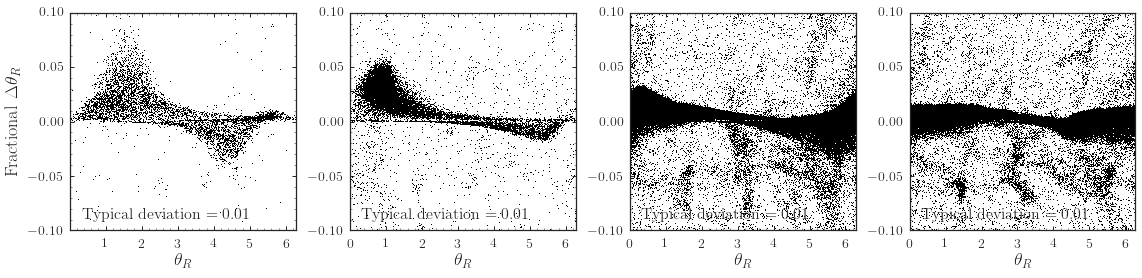

In [15]:
figsize(16,4)
plotIndx= 6
subplot(1,4,1)
ty=  ((acfs_0p125_after[plotIndx,debrisIndx_0p125]-acfs_0p125_until[plotIndx,debrisIndx_0p125]\
                    -acfs_0p125_until[plotIndx-3,debrisIndx_0p125]*0.25*0.9777922212082034/bovy_conversion.time_in_Gyr(V0,R0)
                      +numpy.pi) % (2.*numpy.pi)-numpy.pi)\
                    /(acfs_0p125_until[plotIndx-3,debrisIndx_0p125]*0.25*0.9777922212082034/bovy_conversion.time_in_Gyr(V0,R0))
bovy_plot.bovy_plot(acfs_0p125_after[plotIndx,debrisIndx_0p125],ty,
                    'k,',
                    gcf=True,
                    xlabel=r'$\theta_R$',
                    ylabel=r'$\mathrm{Fractional}\ \Delta \theta_R$',
                    yrange=[-0.1,0.1])
bovy_plot.bovy_text(r'$\mathrm{Typical\ deviation} = %.2f$' % (numpy.median(numpy.fabs(ty-numpy.median(ty)))),
                   bottom_left=True,size=16.)
subplot(1,4,2)
ty= ((acfs_0p25_after[plotIndx,debrisIndx_0p25]-acfs_0p25_until[plotIndx,debrisIndx_0p25]\
     -acfs_0p25_until[plotIndx-3,debrisIndx_0p25]*0.25*0.9777922212082034/bovy_conversion.time_in_Gyr(V0,R0)+numpy.pi) % (2.*numpy.pi)
     -numpy.pi)/(acfs_0p25_until[plotIndx-3,debrisIndx_0p25]*0.25*0.9777922212082034/bovy_conversion.time_in_Gyr(V0,R0))
bovy_plot.bovy_plot(acfs_0p25_after[plotIndx,debrisIndx_0p25],ty,
                    'k,',gcf=True,
                    xlabel=r'$\theta_R$',
                    yrange=[-0.1,0.1])
bovy_plot.bovy_text(r'$\mathrm{Typical\ deviation} = %.2f$' % (numpy.median(numpy.fabs(ty-numpy.median(ty)))),
                   bottom_left=True,size=16.)
subplot(1,4,3)
ty= ((acfs_0p375_after[plotIndx,debrisIndx_0p375]-acfs_0p375_until[plotIndx,debrisIndx_0p375]\
     -acfs_0p375_until[plotIndx-3,debrisIndx_0p375]*0.25*0.9777922212082034/bovy_conversion.time_in_Gyr(V0,R0)+numpy.pi) % (2.*numpy.pi)
     -numpy.pi)/(acfs_0p375_until[plotIndx-3,debrisIndx_0p375]*0.25*0.9777922212082034/bovy_conversion.time_in_Gyr(V0,R0))
bovy_plot.bovy_plot(acfs_0p375_after[plotIndx,debrisIndx_0p375],ty,
                    'k,',gcf=True,
                    xlabel=r'$\theta_R$',
                    yrange=[-0.1,0.1])
bovy_plot.bovy_text(r'$\mathrm{Typical\ deviation} = %.2f$' % (numpy.median(numpy.fabs(ty-numpy.median(ty)))),
                   bottom_left=True,size=16.)
subplot(1,4,4)
ty= ((acfs_0p5_after[plotIndx,debrisIndx_0p5]-acfs_0p5_until[plotIndx,debrisIndx_0p5]\
     -acfs_0p5_until[plotIndx-3,debrisIndx_0p5]*0.25*0.9777922212082034/bovy_conversion.time_in_Gyr(V0,R0)+numpy.pi) % (2.*numpy.pi)
     -numpy.pi)/(acfs_0p5_until[plotIndx-3,debrisIndx_0p5]*0.25*0.9777922212082034/bovy_conversion.time_in_Gyr(V0,R0))
bovy_plot.bovy_plot(acfs_0p5_after[plotIndx,debrisIndx_0p5],ty,
                    'k,',gcf=True,
                    xlabel=r'$\theta_R$',
                    yrange=[-0.1,0.1])
bovy_plot.bovy_text(r'$\mathrm{Typical\ deviation} = %.2f$' % (numpy.median(numpy.fabs(ty-numpy.median(ty)))),
                   bottom_left=True,size=16.)
tight_layout()

The densities in the DM streams before, at, and after impact are (including remaining progenitor):

In [16]:
# We compute the frequency of the DM orbit, to compute the parallel angle and frequency
aAI= actionAngleIsochroneApprox(pot=lp,b=0.8)
aa_dm= aAI.actionsFreqsAngles(dm_impact().flip())
oparDir_dm= numpy.array([aa_dm[3],aa_dm[4],aa_dm[5]])
oparDir_dm/= numpy.sqrt(numpy.sum(oparDir_dm**2.))
from stream2_util import calc_apars_dm, calc_opars_dm
opar_dm= numpy.sum(numpy.array([aa_dm[3],aa_dm[4],aa_dm[5]])*oparDir_dm)
print opar_dm*0.125*0.9777922212082034/bovy_conversion.time_in_Gyr(V0,R0), (-0.8+opar_dm*0.25*0.9777922212082034/bovy_conversion.time_in_Gyr(V0,R0))-2.*numpy.pi
print aa_dm[6:]

4.46013492694 1.83708454671
(array([ 3.02831488]), array([ 2.99842392]), array([ 6.08686238]))


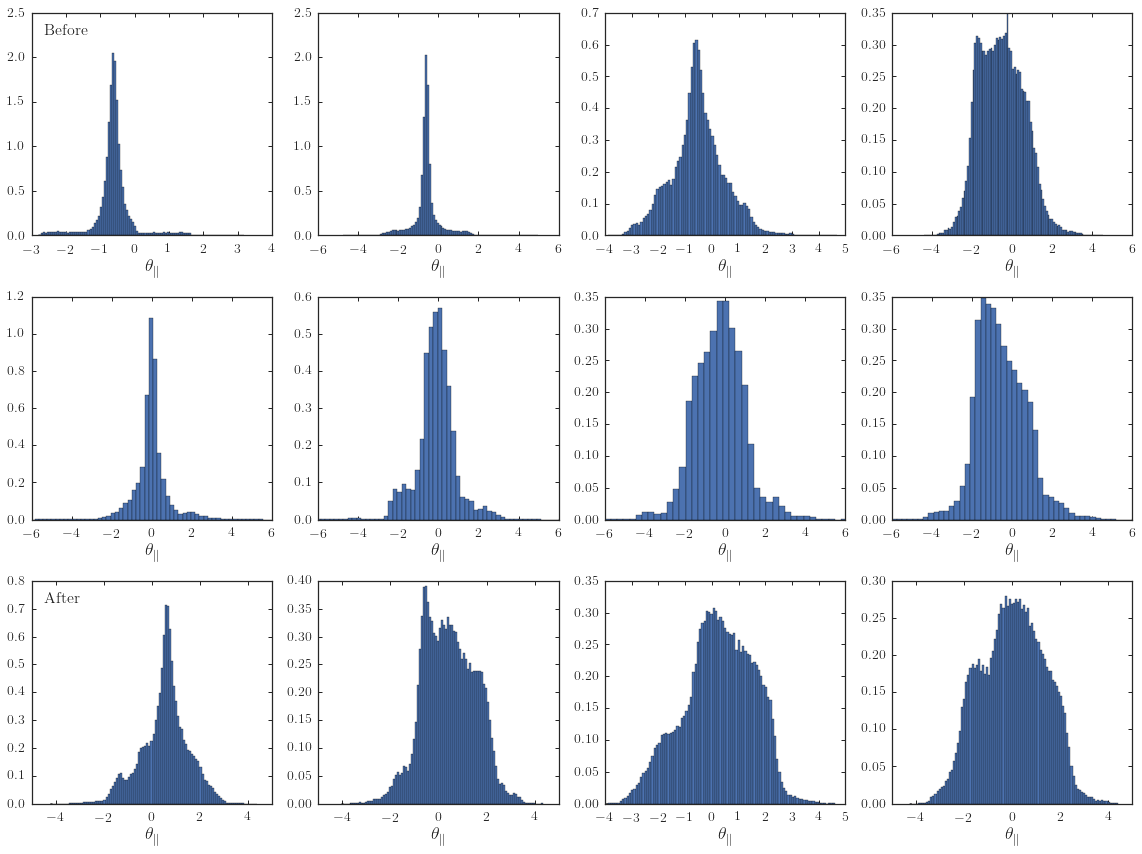

In [17]:
figsize(16,12)
subplot(3,4,1)
apar_0p125_until= calc_apars_dm((acfs_0p125_until[6]+numpy.pi)%(2.*numpy.pi)-numpy.pi,acfs_0p125_until[7],acfs_0p125_until[8],
                                aa_dm,oparDir_dm)
dum= hist(apar_0p125_until[True^numpy.isnan(apar_0p125_until)],bins=101,normed=True)
xlabel(r'$\theta_\parallel$')
bovy_plot.bovy_text(r'$\mathrm{Before}$',top_left=True,size=16.)
subplot(3,4,2)
apar_0p25_until= calc_apars_dm((acfs_0p25_until[6]+numpy.pi)%(2.*numpy.pi)-numpy.pi,acfs_0p25_until[7],acfs_0p25_until[8],
                              aa_dm,oparDir_dm)
dum= hist(apar_0p25_until[True^numpy.isnan(apar_0p25_until)],bins=101,normed=True)
xlabel(r'$\theta_\parallel$')
subplot(3,4,3)
apar_0p375_until= calc_apars_dm((acfs_0p375_until[6]+numpy.pi)%(2.*numpy.pi)-numpy.pi,acfs_0p375_until[7],acfs_0p375_until[8],
                               aa_dm,oparDir_dm)
dum= hist(apar_0p375_until[True^numpy.isnan(apar_0p375_until)],bins=101,normed=True)
xlabel(r'$\theta_\parallel$')
subplot(3,4,4)
apar_0p5_until= calc_apars_dm((acfs_0p5_until[6]+numpy.pi)%(2.*numpy.pi)-numpy.pi,acfs_0p5_until[7],acfs_0p5_until[8],
                             aa_dm,oparDir_dm)
dum= hist(apar_0p5_until[True^numpy.isnan(apar_0p5_until)],bins=101,normed=True)
xlabel(r'$\theta_\parallel$')
subplot(3,4,5)
apar_0p125_impact= calc_apars_dm(2.*numpy.pi+(acfs_0p125_after[6]+numpy.pi)%(2.*numpy.pi)
                                 -numpy.pi-acfs_0p125_after[3]*0.125*0.9777922212082034/bovy_conversion.time_in_Gyr(V0,R0)-aa_dm[6],
                                 acfs_0p125_after[7]-acfs_0p125_after[4]*0.125*0.9777922212082034/bovy_conversion.time_in_Gyr(V0,R0)-aa_dm[7],
                                 2.*numpy.pi+acfs_0p125_after[8]-acfs_0p125_after[5]*0.125*0.9777922212082034/bovy_conversion.time_in_Gyr(V0,R0)-aa_dm[8],
                                aa_dm,oparDir_dm)
dum= hist(apar_0p125_impact[True^numpy.isnan(apar_0p125_impact)],bins=101,normed=True)
xlabel(r'$\theta_\parallel$')
xlim(-6.,6.)
subplot(3,4,6)
apar_0p25_impact= calc_apars_dm(2.*numpy.pi+(acfs_0p25_after[6]+numpy.pi)%(2.*numpy.pi)
                                 -numpy.pi-acfs_0p25_after[3]*0.125*0.9777922212082034/bovy_conversion.time_in_Gyr(V0,R0)-aa_dm[6],
                                 acfs_0p25_after[7]-acfs_0p25_after[4]*0.125*0.9777922212082034/bovy_conversion.time_in_Gyr(V0,R0)-aa_dm[7],
                                 2.*numpy.pi+acfs_0p25_after[8]-acfs_0p25_after[5]*0.125*0.9777922212082034/bovy_conversion.time_in_Gyr(V0,R0)-aa_dm[8],
                               aa_dm,oparDir_dm)
dum= hist(apar_0p25_impact[True^numpy.isnan(apar_0p25_impact)],bins=101,normed=True)
xlabel(r'$\theta_\parallel$')
xlim(-6.,6.)
subplot(3,4,7)
apar_0p375_impact= calc_apars_dm(2.*numpy.pi+(acfs_0p375_after[6]+numpy.pi)%(2.*numpy.pi)
                                 -numpy.pi-acfs_0p375_after[3]*0.125*0.9777922212082034/bovy_conversion.time_in_Gyr(V0,R0)-aa_dm[6],
                                 acfs_0p375_after[7]-acfs_0p375_after[4]*0.125*0.9777922212082034/bovy_conversion.time_in_Gyr(V0,R0)-aa_dm[7],
                                 2.*numpy.pi+acfs_0p375_after[8]-acfs_0p375_after[5]*0.125*0.9777922212082034/bovy_conversion.time_in_Gyr(V0,R0)-aa_dm[8],
                                aa_dm,oparDir_dm)
dum= hist(apar_0p375_impact[True^numpy.isnan(apar_0p375_impact)],bins=101,normed=True)
xlabel(r'$\theta_\parallel$')
xlim(-6.,6.)
subplot(3,4,8)
apar_0p5_impact= calc_apars_dm(2.*numpy.pi+(acfs_0p5_after[6]+numpy.pi)%(2.*numpy.pi)
                                 -numpy.pi-acfs_0p5_after[3]*0.125*0.9777922212082034/bovy_conversion.time_in_Gyr(V0,R0)-aa_dm[6],
                                 acfs_0p5_after[7]-acfs_0p5_after[4]*0.125*0.9777922212082034/bovy_conversion.time_in_Gyr(V0,R0)-aa_dm[7],
                                 2.*numpy.pi+acfs_0p5_after[8]-acfs_0p5_after[5]*0.125*0.9777922212082034/bovy_conversion.time_in_Gyr(V0,R0)-aa_dm[8],
                              aa_dm,oparDir_dm)
dum= hist(apar_0p5_impact[True^numpy.isnan(apar_0p5_impact)],bins=101,normed=True)
xlabel(r'$\theta_\parallel$')
xlim(-6.,6.)
subplot(3,4,9)
apar_0p125= calc_apars_dm((acfs_0p125_after[6]+numpy.pi)%(2.*numpy.pi)-numpy.pi,acfs_0p125_after[7],acfs_0p125_after[8],
                         aa_dm,oparDir_dm)
dum= hist(apar_0p125[True^numpy.isnan(apar_0p125)],bins=101,normed=True)
xlabel(r'$\theta_\parallel$')
bovy_plot.bovy_text(r'$\mathrm{After}$',top_left=True,size=16.)
subplot(3,4,10)
apar_0p25= calc_apars_dm((acfs_0p25_after[6]+numpy.pi)%(2.*numpy.pi)-numpy.pi,acfs_0p25_after[7],acfs_0p25_after[8],
                        aa_dm,oparDir_dm)
dum= hist(apar_0p25[True^numpy.isnan(apar_0p25)],bins=101,normed=True)
xlabel(r'$\theta_\parallel$')
subplot(3,4,11)
apar_0p375= calc_apars_dm((acfs_0p375_after[6]+numpy.pi)%(2.*numpy.pi)-numpy.pi,acfs_0p375_after[7],acfs_0p375_after[8],
                         aa_dm,oparDir_dm)
dum= hist(apar_0p375[True^numpy.isnan(apar_0p375)],bins=101,normed=True)
xlabel(r'$\theta_\parallel$')
subplot(3,4,12)
apar_0p5= calc_apars_dm((acfs_0p5_after[6]+numpy.pi)%(2.*numpy.pi)-numpy.pi,acfs_0p5_after[7],acfs_0p5_after[8],
                       aa_dm,oparDir_dm)
dum= hist(apar_0p5[True^numpy.isnan(apar_0p5)],bins=101,normed=True)
xlabel(r'$\theta_\parallel$')
tight_layout()

The distribution of times at which the DM stream passes through the impact point is:

(-2.5, 2.5)

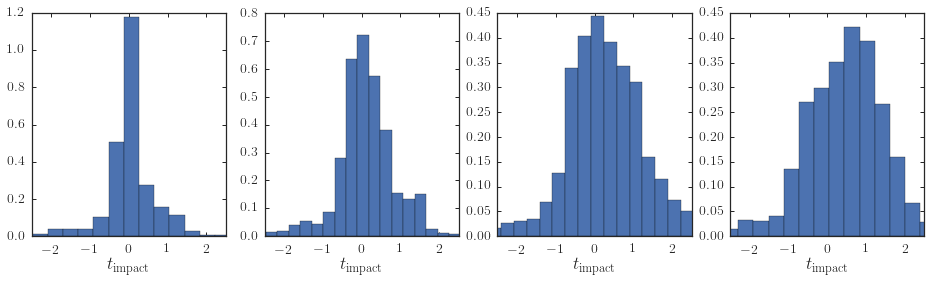

In [18]:
figsize(16,4)
subplot(1,4,1)
opar_0p125= calc_opars_dm(acfs_0p125_after[3],acfs_0p125_after[4],acfs_0p125_after[5],oparDir_dm)
dt_0p125= -apar_0p125_impact/opar_0p125
dum= hist(dt_0p125[True^numpy.isnan(dt_0p125)],bins=101,normed=True)
xlabel(r'$t_{\mathrm{impact}}$')
xlim(-2.5,2.5)
subplot(1,4,2)
opar_0p25= calc_opars_dm(acfs_0p25_after[3],acfs_0p25_after[4],acfs_0p25_after[5],oparDir_dm)
dt_0p25= -apar_0p25_impact/opar_0p25
dum= hist(dt_0p25[True^numpy.isnan(dt_0p25)],bins=101,normed=True)
xlabel(r'$t_{\mathrm{impact}}$')
xlim(-2.5,2.5)
subplot(1,4,3)
opar_0p375= calc_opars_dm(acfs_0p375_after[3],acfs_0p375_after[4],acfs_0p375_after[5],oparDir_dm)
dt_0p375= -apar_0p375_impact/opar_0p375
dum= hist(dt_0p375[True^numpy.isnan(dt_0p375)],bins=101,normed=True)
xlabel(r'$t_{\mathrm{impact}}$')
xlim(-2.5,2.5)
subplot(1,4,4)
opar_0p5= calc_opars_dm(acfs_0p5_after[3],acfs_0p5_after[4],acfs_0p5_after[5],oparDir_dm)
dt_0p5= -apar_0p5_impact/opar_0p5
dum= hist(dt_0p5[True^numpy.isnan(dt_0p5)],bins=101,normed=True)
xlabel(r'$t_{\mathrm{impact}}$')
xlim(-2.5,2.5)

## Kicks

In [19]:
# Stream particles only, to limit the amount of orbit integration
thetap= (numpy.pi+(acfs[7]-numpy.median(acfs[7]))) % (2.*numpy.pi)
indx= numpy.fabs(thetap-numpy.pi) > (8.*numpy.median(numpy.fabs(thetap-numpy.median(thetap))))
#indx= numpy.sqrt((snap_gc[:,1,-1]+13.500000)**2.\
#                 +(snap_gc[:,2,-1]+1.840000)**2.\
#                 +(snap_gc[:,3,-1]-2.840000)**2.) < 20.
# times for orbit integration
times= numpy.linspace(0.,0.125*0.9777922212082034/bovy_conversion.time_in_Gyr(V0,R0),101)
snapvdiff_dm0p125= numpy.zeros((len(snap_gc),3))
snapvdiff_dm0p25= numpy.zeros((len(snap_gc),3))
snapvdiff_dm0p375= numpy.zeros((len(snap_gc),3))
snapvdiff_dm0p5= numpy.zeros((len(snap_gc),3))
check_zeropoint= False
if check_zeropoint:
    snapvdiff_zeropoint= numpy.zeros((len(snap_gc),3))
for ii in range(len(snap_gc)):
    if not indx[ii]: continue
    # Integrate backwards to the impact
    RvR= rectangular_to_cylindrical(snap_dm0p125_after[ii,1:,-1][:,numpy.newaxis].T)[0,:]
    orb= Orbit([RvR[0]/R0,RvR[1]/V0,RvR[2]/V0,
                RvR[3]/R0,RvR[4]/V0,RvR[5]],ro=R0,vo=V0).flip()
    orb.integrate(times,lp)
    snapvdiff_dm0p125[ii,0]= -orb.vx(times[-1])-snap_gc[ii,4,-1]
    snapvdiff_dm0p125[ii,1]= -orb.vy(times[-1])-snap_gc[ii,5,-1]
    snapvdiff_dm0p125[ii,2]= -orb.vz(times[-1])-snap_gc[ii,6,-1]
    # Integrate backwards to the impact
    RvR= rectangular_to_cylindrical(snap_dm0p25_after[ii,1:,-1][:,numpy.newaxis].T)[0,:]
    orb= Orbit([RvR[0]/R0,RvR[1]/V0,RvR[2]/V0,
                RvR[3]/R0,RvR[4]/V0,RvR[5]],ro=R0,vo=V0).flip()
    orb.integrate(times,lp)
    snapvdiff_dm0p25[ii,0]= -orb.vx(times[-1])-snap_gc[ii,4,-1]
    snapvdiff_dm0p25[ii,1]= -orb.vy(times[-1])-snap_gc[ii,5,-1]
    snapvdiff_dm0p25[ii,2]= -orb.vz(times[-1])-snap_gc[ii,6,-1]
    # Integrate backwards to the impact
    RvR= rectangular_to_cylindrical(snap_dm0p375_after[ii,1:,-1][:,numpy.newaxis].T)[0,:]
    orb= Orbit([RvR[0]/R0,RvR[1]/V0,RvR[2]/V0,
                RvR[3]/R0,RvR[4]/V0,RvR[5]],ro=R0,vo=V0).flip()
    orb.integrate(times,lp)
    snapvdiff_dm0p375[ii,0]= -orb.vx(times[-1])-snap_gc[ii,4,-1]
    snapvdiff_dm0p375[ii,1]= -orb.vy(times[-1])-snap_gc[ii,5,-1]
    snapvdiff_dm0p375[ii,2]= -orb.vz(times[-1])-snap_gc[ii,6,-1]
    # Integrate backwards to the impact
    RvR= rectangular_to_cylindrical(snap_dm0p5_after[ii,1:,-1][:,numpy.newaxis].T)[0,:]
    orb= Orbit([RvR[0]/R0,RvR[1]/V0,RvR[2]/V0,
                RvR[3]/R0,RvR[4]/V0,RvR[5]],ro=R0,vo=V0).flip()
    orb.integrate(times,lp)
    snapvdiff_dm0p5[ii,0]= -orb.vx(times[-1])-snap_gc[ii,4,-1]
    snapvdiff_dm0p5[ii,1]= -orb.vy(times[-1])-snap_gc[ii,5,-1]
    snapvdiff_dm0p5[ii,2]= -orb.vz(times[-1])-snap_gc[ii,6,-1]
    if check_zeropoint:
        # Integrate the unperturbed stream backwards to the impact, to check the zeropoint of dv
        RvR= rectangular_to_cylindrical(snap_gc[ii,1:,-4][:,numpy.newaxis].T)[0,:]
        orb= Orbit([RvR[0]/R0,RvR[1]/V0,RvR[2]/V0,
                    RvR[3]/R0,RvR[4]/V0,RvR[5]],ro=R0,vo=V0).flip()
        orb.integrate(times,lp)
        snapvdiff_zeropoint[ii,0]= -orb.vx(times[-1])-snap_gc[ii,4,-1]
        snapvdiff_zeropoint[ii,1]= -orb.vy(times[-1])-snap_gc[ii,5,-1]
        snapvdiff_zeropoint[ii,2]= -orb.vz(times[-1])-snap_gc[ii,6,-1]

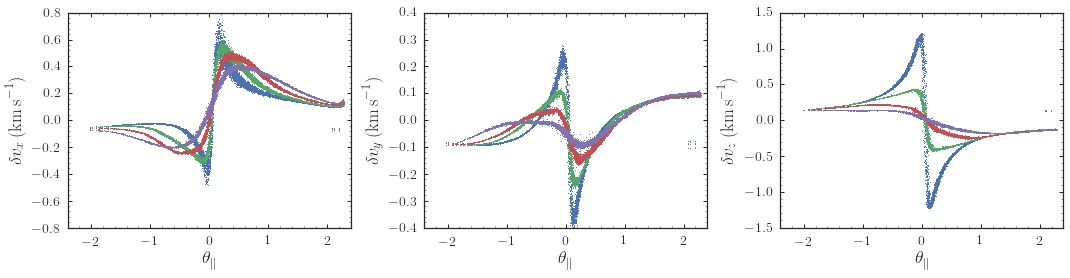

In [20]:
figsize(15,4)
subplot(1,3,1)
bovy_plot.bovy_plot(apar[indx]+2.4,
                    snapvdiff_dm0p125[indx,0],
                    ',',color=sns.color_palette()[0],
                    xrange=[-2.4,2.4],
                    yrange=[-.8,.8],
                    gcf=True,
                    xlabel=r'$\theta_\parallel$',
                    ylabel=r'$\delta v_x\,(\mathrm{km\,s}^{-1})$')
plot(apar[indx]+2.4,snapvdiff_dm0p25[indx,0],',',color=sns.color_palette()[1])
plot(apar[indx]+2.4,snapvdiff_dm0p375[indx,0],',',color=sns.color_palette()[2])
plot(apar[indx]+2.4,snapvdiff_dm0p5[indx,0],',',color=sns.color_palette()[3])
if check_zeropoint:
    plot(apar[indx]+2.4,snapvdiff_zeropoint[indx,0],',',color='k')
subplot(1,3,2)
bovy_plot.bovy_plot(apar[indx]+2.4,
                    snapvdiff_dm0p125[indx,1],
                    ',',color=sns.color_palette()[0],
                    xrange=[-2.4,2.4],
                    yrange=[-.4,.4],
                    gcf=True,
                    xlabel=r'$\theta_\parallel$',
                    ylabel=r'$\delta v_y\,(\mathrm{km\,s}^{-1})$')
plot(apar[indx]+2.4,snapvdiff_dm0p25[indx,1],',',color=sns.color_palette()[1])
plot(apar[indx]+2.4,snapvdiff_dm0p375[indx,1],',',color=sns.color_palette()[2])
plot(apar[indx]+2.4,snapvdiff_dm0p5[indx,1],',',color=sns.color_palette()[3])
if check_zeropoint:
    plot(apar[indx]+2.4,snapvdiff_zeropoint[indx,1],',',color='k')
subplot(1,3,3)
bovy_plot.bovy_plot(apar[indx]+2.4,
                    snapvdiff_dm0p125[indx,2],
                    ',',color=sns.color_palette()[0],
                    xrange=[-2.4,2.4],
                    yrange=[-1.5,1.5],
                    gcf=True,
                    xlabel=r'$\theta_\parallel$',
                    ylabel=r'$\delta v_z\,(\mathrm{km\,s}^{-1})$')
plot(apar[indx]+2.4,snapvdiff_dm0p25[indx,2],',',color=sns.color_palette()[1])
plot(apar[indx]+2.4,snapvdiff_dm0p375[indx,2],',',color=sns.color_palette()[2])
plot(apar[indx]+2.4,snapvdiff_dm0p5[indx,2],',',color=sns.color_palette()[3])
if check_zeropoint:
    plot(apar[indx]+2.4,snapvdiff_zeropoint[indx,2],',',color='k')
tight_layout()

## Calculating the kicks analytically in the impulse approximation

In [21]:
reload(calc_deltav)
v_gc, x_gc, t_gc, apar_gc= calc_deltav.vxta_deltav(snap_gc,apar,acfs)

In [22]:
stream_orbit= calc_deltav.get_stream_orbit(snap_gc,apar)

In [23]:
#dt= 1.#/bovy_conversion.time_in_Gyr(V0,R0)
#GSigma= lambda t: 10.**-2./bovy_conversion.mass_in_1010msol(V0,R0)/dt if numpy.fabs(t) < dt/2. else 0.
b, e= numpy.histogram(dt_0p125[True^numpy.isnan(dt_0p125)],bins=101,normed=True,range=[-2.5,2.5])
tInterp_0p125= interpolate.UnivariateSpline(0.5*(numpy.roll(e,1)+e)[1:],b,k=3,s=0.01)
GSigma_0p125= lambda t: 10.**-2./bovy_conversion.mass_in_1010msol(V0,R0)*tInterp_0p125(t)
b, e= numpy.histogram(dt_0p25[True^numpy.isnan(dt_0p25)],bins=101,normed=True,range=[-2.5,2.5])
tInterp_0p25= interpolate.UnivariateSpline(0.5*(numpy.roll(e,1)+e)[1:],b,k=3,s=0.1)
GSigma_0p25= lambda t: 10.**-2./bovy_conversion.mass_in_1010msol(V0,R0)*tInterp_0p25(t)
b, e= numpy.histogram(dt_0p375[True^numpy.isnan(dt_0p375)],bins=101,normed=True,range=[-3.5,3.5])
tInterp_0p375= interpolate.UnivariateSpline(0.5*(numpy.roll(e,1)+e)[1:],b,k=3,s=0.01)
GSigma_0p375= lambda t: 10.**-2./bovy_conversion.mass_in_1010msol(V0,R0)*tInterp_0p375(t)
b, e= numpy.histogram(dt_0p5[True^numpy.isnan(dt_0p5)]-numpy.nanmedian(dt_0p5),bins=101,normed=True,range=[-3.5,3.5])
tInterp_0p5= interpolate.UnivariateSpline(0.5*(numpy.roll(e,1)+e)[1:],b,k=3,s=0.01)
GSigma_0p5= lambda t: 10.**-2./bovy_conversion.mass_in_1010msol(V0,R0)*tInterp_0p5(t)

In [24]:
dv_def= impulse_deltav_plummer_curvedstream(\
            v_gc,x_gc,0.,numpy.array([6.82200571,132.7700529,149.4174464])/V0,
            numpy.array([-13.500000,2.840000,-1.840000])/R0,
            numpy.array([stream_orbit.vx()[0],stream_orbit.vy()[0],stream_orbit.vz()]),
            10.**-2./bovy_conversion.mass_in_1010msol(V0,R0),
            .450/R0)

In [25]:
dv_0p125= impulse_deltav_plummerstream_curvedstream(\
            v_gc,x_gc,t_gc,0.,numpy.array([6.82200571,132.7700529,149.4174464])/V0,
            numpy.array([-13.500000,2.840000,-1.840000])/R0,
            numpy.array([stream_orbit.vx()[0],stream_orbit.vy()[0],stream_orbit.vz()]),
            GSigma_0p125,
            .1/R0,lp,-2.5,2.5)

In [26]:
dv_0p25= impulse_deltav_plummerstream_curvedstream(\
            v_gc,x_gc,t_gc,0.,numpy.array([6.82200571,132.7700529,149.4174464])/V0,
            numpy.array([-13.500000,2.840000,-1.840000])/R0,
            numpy.array([stream_orbit.vx()[0],stream_orbit.vy()[0],stream_orbit.vz()]),
            GSigma_0p25,
            .1/R0,lp,-2.5,2.5)

In [27]:
dv_0p375= impulse_deltav_plummerstream_curvedstream(\
            v_gc,x_gc,t_gc,0.,numpy.array([6.82200571,132.7700529,149.4174464])/V0,
            numpy.array([-13.500000,2.840000,-1.840000])/R0,
            numpy.array([stream_orbit.vx()[0],stream_orbit.vy()[0],stream_orbit.vz()]),
            GSigma_0p375,
            .1/R0,lp,-3.5,3.5)#-dt/2.,dt/2.)

In [28]:
dv_0p5= impulse_deltav_plummerstream_curvedstream(\
            v_gc,x_gc,t_gc,0.,numpy.array([6.82200571,132.7700529,149.4174464])/V0,
            numpy.array([-13.500000,2.840000,-1.840000])/R0,
            numpy.array([stream_orbit.vx()[0],stream_orbit.vy()[0],stream_orbit.vz()]),
            GSigma_0p5,
            .1/R0,lp,-3.5,3.5)#-dt/2.,dt/2.)

Using an estimated distribution of interaction times, we get

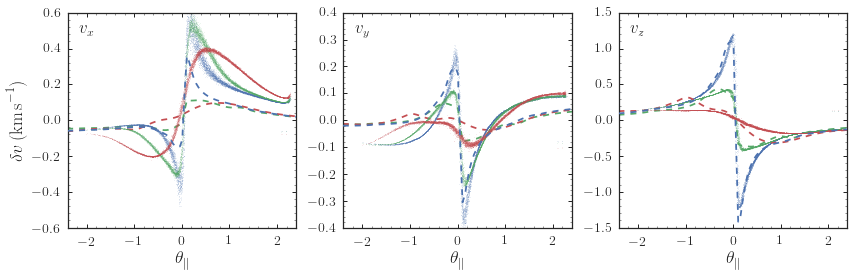

In [29]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(12,4)
alpha= 0.1
subplot(1,3,1)
dv_0p125_tot= dv_0p125*0.6+0.4*dv_def
dv_0p25_tot= dv_0p25*.7+0.1*dv_def
bovy_plot.bovy_plot(apar_gc+2.4,dv_0p125_tot[:,0]*V0,
                    color=sns.color_palette()[0],ls='--',
                    xrange=[-2.4,2.4],
                    yrange=[-.6,.6],
                    gcf=True,zorder=4,
                    xlabel=r'$\theta_\parallel$',
                    ylabel=r'$\delta v\,(\mathrm{km\,s}^{-1})$')
bovy_plot.bovy_text(r'$v_x$',top_left=True,size=17.)
plot(apar_gc+2.4,dv_0p25_tot[:,0]*V0,color=sns.color_palette()[1],ls='--')
plot(apar_gc+2.4,dv_0p5[:,0]*V0,color=sns.color_palette()[2],ls='--',)
plot(apar[indx]+2.4,snapvdiff_dm0p125[indx,0],',',color=sns.color_palette()[0],alpha=alpha)
plot(apar[indx]+2.4,snapvdiff_dm0p25[indx,0],',',color=sns.color_palette()[1],alpha=alpha)
plot(apar[indx]+2.4,snapvdiff_dm0p5[indx,0],',',color=sns.color_palette()[2],alpha=alpha)
subplot(1,3,2)
bovy_plot.bovy_plot(apar_gc+2.4,dv_0p125_tot[:,1]*V0,
                    color=sns.color_palette()[0],ls='--',
                    xrange=[-2.4,2.4],
                    yrange=[-.4,.4],
                    gcf=True,zorder=4,
                    xlabel=r'$\theta_\parallel$')
bovy_plot.bovy_text(r'$v_y$',top_left=True,size=17.)
plot(apar_gc+2.4,dv_0p25_tot[:,1]*V0,color=sns.color_palette()[1],ls='--')
plot(apar_gc+2.4,dv_0p5[:,1]*V0,color=sns.color_palette()[2],ls='--')
plot(apar[indx]+2.4,snapvdiff_dm0p125[indx,1],',',color=sns.color_palette()[0],alpha=alpha)
plot(apar[indx]+2.4,snapvdiff_dm0p25[indx,1],',',color=sns.color_palette()[1],alpha=alpha)
plot(apar[indx]+2.4,snapvdiff_dm0p5[indx,1],',',color=sns.color_palette()[2],alpha=alpha)
subplot(1,3,3)
bovy_plot.bovy_plot(apar_gc+2.4,dv_0p125_tot[:,2]*V0,
                    color=sns.color_palette()[0],ls='--',
                    xrange=[-2.4,2.4],
                    yrange=[-1.5,1.5],
                    gcf=True,zorder=4,
                    xlabel=r'$\theta_\parallel$')
bovy_plot.bovy_text(r'$v_z$',top_left=True,size=17.)
plot(apar_gc+2.4,dv_0p25_tot[:,2]*V0,color=sns.color_palette()[1],ls='--')
plot(apar_gc+2.4,dv_0p5[:,2]*V0,color=sns.color_palette()[2],ls='--')
plot(apar[indx]+2.4,snapvdiff_dm0p125[indx,2],',',color=sns.color_palette()[0],alpha=alpha,zorder=1)
plot(apar[indx]+2.4,snapvdiff_dm0p25[indx,2],',',color=sns.color_palette()[1],alpha=alpha)
plot(apar[indx]+2.4,snapvdiff_dm0p5[indx,2],',',color=sns.color_palette()[2],alpha=alpha)
tight_layout()

## Direct-integration kicks

We compute the kicks using direct integration with a random subset of 300 DM stream particles and compare it to the full *N*-body calculation and the simpler impulse approximation:

In [30]:
dv_0p125_fullplummer= calc_deltav.calc_fullplummer_deltav(\
                       '0.125',os.path.join(os.getenv('DATADIR'),
                                           'bovy','stream-stream',
                                           'deltav_0.125_fullplummer.sav'),
                        None,None,None)
dv_0p125_fullplummer= 10./dv_0p125_fullplummer.shape[2]\
                        *numpy.sum(gaussian_filter1d(dv_0p125_fullplummer,1.,axis=0),axis=-1)*0.6+0.4*dv_def
dv_0p25_fullplummer= calc_deltav.calc_fullplummer_deltav(\
                       '0.25',os.path.join(os.getenv('DATADIR'),
                                           'bovy','stream-stream',
                                           'deltav_0.25_fullplummer.sav'),
                        None,None,None)
dv_0p25_fullplummer= 10./dv_0p25_fullplummer.shape[2]\
                        *numpy.sum(gaussian_filter1d(dv_0p25_fullplummer,1.5,axis=0),axis=-1)*0.825+0.175*dv_def
dv_0p5_fullplummer= calc_deltav.calc_fullplummer_deltav(\
                       '0.50',os.path.join(os.getenv('DATADIR'),
                                           'bovy','stream-stream',
                                           'deltav_0.50_fullplummer.sav'),
                        None,None,None)
dv_0p5_fullplummer= 10./dv_0p5_fullplummer.shape[2]\
                    *numpy.sum(gaussian_filter1d(dv_0p5_fullplummer,3,axis=0),axis=-1)

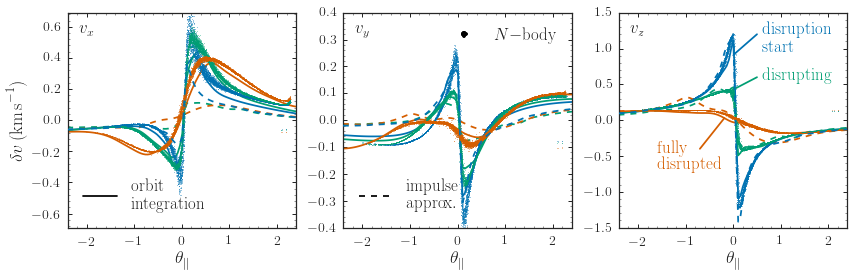

In [31]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(12,4)
if save_figures:
    alpha= .4
    marker= '.'
    ms=2.
else:
    alpha= 0.4
    marker= ','
    ms= 1.
subplot(1,3,1)
dv_0p125_tot= dv_0p125*0.6+0.4*dv_def
dv_0p25_tot= dv_0p25*.7+0.1*dv_def
pindx= indx*(numpy.fabs(apar+2.4) <= 2.4)
bovy_plot.bovy_plot(apar_gc+2.4,dv_0p125_tot[:,0]*V0,
                    color=sns.color_palette("colorblind")[0],ls='--',
                    xrange=[-2.4,2.4],
                    yrange=[-.69,.69],
                    gcf=True,zorder=4,
                    xlabel=r'$\theta_\parallel$',
                    ylabel=r'$\delta v\,(\mathrm{km\,s}^{-1})$')
bovy_plot.bovy_text(r'$v_x$',top_left=True,size=17.)
plot(apar_gc+2.4,dv_0p25_tot[:,0]*V0,color=sns.color_palette("colorblind")[1],ls='--')
plot(apar_gc+2.4,dv_0p5[:,0]*V0,color=sns.color_palette("colorblind")[2],ls='--')
plot(apar_gc+2.4,dv_0p125_fullplummer[:,0]*V0,color=sns.color_palette("colorblind")[0])
plot(apar_gc+2.4,dv_0p25_fullplummer[:,0]*V0,color=sns.color_palette("colorblind")[1])
plot(apar_gc+2.4,dv_0p5_fullplummer[:,0]*V0,color=sns.color_palette("colorblind")[2])
plot(apar[pindx]+2.4,snapvdiff_dm0p125[pindx,0],marker,color=sns.color_palette("colorblind")[0],
     alpha=alpha,rasterized=True,ms=ms)
plot(apar[pindx]+2.4,snapvdiff_dm0p25[pindx,0],marker,color=sns.color_palette("colorblind")[1],
     alpha=alpha,rasterized=True,ms=ms)
plot(apar[pindx]+2.4,snapvdiff_dm0p5[pindx,0],marker,color=sns.color_palette("colorblind")[2],
     alpha=alpha,rasterized=True,ms=ms)
pyplot.legend((mlines.Line2D([], [], color='k',ls='-'),),
              (r'$\mathrm{orbit}$'+'\n'+r'$\mathrm{integration}$',),
               loc='lower left',#bbox_to_anchor=(.02,.02),
               numpoints=1,
               prop={'size':17},
               frameon=False)
subplot(1,3,2)
bovy_plot.bovy_plot(apar_gc+2.4,dv_0p125_tot[:,1]*V0,
                    color=sns.color_palette("colorblind")[0],ls='--',
                    xrange=[-2.4,2.4],
                    yrange=[-.4,.4],
                    gcf=True,zorder=4,
                    xlabel=r'$\theta_\parallel$')
bovy_plot.bovy_text(r'$v_y$',top_left=True,size=17.)
plot(apar_gc+2.4,dv_0p25_tot[:,1]*V0,color=sns.color_palette("colorblind")[1],ls='--')
plot(apar_gc+2.4,dv_0p5[:,1]*V0,color=sns.color_palette("colorblind")[2],ls='--')
plot(apar_gc+2.4,dv_0p125_fullplummer[:,1]*V0,color=sns.color_palette("colorblind")[0])
plot(apar_gc+2.4,dv_0p25_fullplummer[:,1]*V0,color=sns.color_palette("colorblind")[1])
plot(apar_gc+2.4,dv_0p5_fullplummer[:,1]*V0,color=sns.color_palette("colorblind")[2])
plot(apar[pindx]+2.4,snapvdiff_dm0p125[pindx,1],marker,color=sns.color_palette("colorblind")[0],
     alpha=alpha,rasterized=True,ms=ms)
plot(apar[pindx]+2.4,snapvdiff_dm0p25[pindx,1],marker,color=sns.color_palette("colorblind")[1],
     alpha=alpha,rasterized=True,ms=ms)
plot(apar[pindx]+2.4,snapvdiff_dm0p5[pindx,1],marker,color=sns.color_palette("colorblind")[2],
     alpha=alpha,rasterized=True,ms=ms)
l1= pyplot.legend((mlines.Line2D([], [], color='k',marker='o',ls='none'),),
              (r'$N\mathrm{-body}$',),
               loc='upper right',#bbox_to_anchor=(.02,.02),
               numpoints=1,
               prop={'size':17},
               frameon=False)
pyplot.legend((mlines.Line2D([], [], color='k',ls='--'),),
              (r'$\mathrm{impulse}$'+'\n'+r'$\mathrm{approx.}$',),
               loc='lower left',#bbox_to_anchor=(.02,.02),
               numpoints=1,
               prop={'size':17},
               frameon=False)
pyplot.gca().add_artist(l1)
subplot(1,3,3)
bovy_plot.bovy_plot(apar_gc+2.4,dv_0p125_tot[:,2]*V0,
                    color=sns.color_palette("colorblind")[0],ls='--',
                    xrange=[-2.4,2.4],
                    yrange=[-1.5,1.5],
                    gcf=True,zorder=4,
                    xlabel=r'$\theta_\parallel$')
bovy_plot.bovy_text(r'$v_z$',top_left=True,size=17.)
plot(apar_gc+2.4,dv_0p25_tot[:,2]*V0,color=sns.color_palette("colorblind")[1],ls='--')
plot(apar_gc+2.4,dv_0p5[:,2]*V0,color=sns.color_palette("colorblind")[2],ls='--')
plot(apar_gc+2.4,dv_0p125_fullplummer[:,2]*V0,color=sns.color_palette("colorblind")[0])
plot(apar_gc+2.4,dv_0p25_fullplummer[:,2]*V0,color=sns.color_palette("colorblind")[1])
plot(apar_gc+2.4,dv_0p5_fullplummer[:,2]*V0,color=sns.color_palette("colorblind")[2])
plot(apar[pindx]+2.4,snapvdiff_dm0p125[pindx,2],marker,color=sns.color_palette("colorblind")[0],
     alpha=alpha,zorder=1,rasterized=True,ms=ms)
plot(apar[pindx]+2.4,snapvdiff_dm0p25[pindx,2],marker,color=sns.color_palette("colorblind")[1],
     alpha=alpha,rasterized=True,ms=ms)
plot(apar[pindx]+2.4,snapvdiff_dm0p5[pindx,2],marker,color=sns.color_palette("colorblind")[2],
     alpha=alpha,rasterized=True,ms=ms)
# Label
plot([apar_gc[50]+2.4,0.5],[dv_0p125_fullplummer[50,2]*V0-0.2,1.2],color=sns.color_palette("colorblind")[0])
bovy_plot.bovy_text(0.6,0.95,r'$\mathrm{disruption}$'+'\n'+r'$\mathrm{start}$',
                   size=17.,color=sns.color_palette("colorblind")[0])
plot([apar_gc[47]+2.4,0.5],[dv_0p25_tot[47,2]*V0,.6],color=sns.color_palette("colorblind")[1])
bovy_plot.bovy_text(0.6,0.55,r'$\mathrm{disrupting}$',
                   size=17.,color=sns.color_palette("colorblind")[1])
plot([apar_gc[46]+2.4,-0.7],[dv_0p5_fullplummer[46,2]*V0,-0.4],color=sns.color_palette("colorblind")[2])
bovy_plot.bovy_text(-1.6,-0.7,r'$\mathrm{fully}$'+'\n'+r'$\mathrm{disrupted}$',
                   size=17.,color=sns.color_palette("colorblind")[2])
tight_layout()
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2015-stream-stream','fig3.pdf'),
                            dpi=600)